<a href="https://colab.research.google.com/github/amruthvkbhat-creator/MachineLearning/blob/main/MachineLearning_24170163.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,5)

data_path = '/content/drive/MyDrive/Colab Notebooks/MachineLearning/Fragrance Dataset - COM7022 - [4037].csv'
df = pd.read_csv(data_path)
print('Loaded', data_path, 'shape', df.shape)

Loaded /content/drive/MyDrive/Colab Notebooks/MachineLearning/Fragrance Dataset - COM7022 - [4037].csv shape (1000, 10)


In [15]:
for c in ['price', 'sold']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [17]:
if 'priceWithCurrency' in df.columns and 'price' in df.columns and df['price'].isnull().any():
    def extract_price(s):
        try:
            return float(re.sub(r'[^\d\.]', '', str(s).split('/')[0]))
        except:
            return np.nan
    df['price'] = df['price'].fillna(df['priceWithCurrency'].apply(extract_price))

In [19]:
if 'available' in df.columns:
    def avail_to_num(v):
        if pd.isna(v): return np.nan
        s=str(v)
        if re.search(r'more than\s*(\d+)', s, re.I):
            return int(re.search(r'more than\s*(\d+)', s, re.I).group(1))
        m=re.search(r'(\d+)', s)
        return int(m.group(1)) if m else np.nan
    df['available_num'] = df['available'].apply(avail_to_num)

In [21]:
if 'sold' not in df.columns and 'availableText' in df.columns:
    def sold_from_text(s):
        if pd.isna(s): return np.nan
        m = re.search(r'(\d+)\s*sold', s, re.I)
        return int(m.group(1)) if m else np.nan
    df['sold'] = df['availableText'].apply(sold_from_text)

In [23]:
if 'lastUpdated' in df.columns:
    df['lastUpdated_parsed'] = pd.to_datetime(df['lastUpdated'], errors='coerce')

In [25]:
if 'itemLocation' in df.columns:
    def extract_country(loc):
        if pd.isna(loc): return 'missing'
        parts = [p.strip() for p in str(loc).split(',') if p.strip()]
        return parts[-1] if parts else 'missing'
    df['location_country'] = df['itemLocation'].apply(extract_country)
    df['location_city'] = df['itemLocation'].apply(lambda x: (str(x).split(',')[0].strip()) if pd.notna(x) else 'missing')

In [27]:
# Feature selection: choose features for clustering
text_cols = [c for c in ['title', 'description', 'type'] if c in df.columns]
numeric_cols = [c for c in ['price', 'sold', 'available_num'] if c in df.columns]
cat_cols = [c for c in ['brand', 'type', 'location_country'] if c in df.columns]

In [29]:
print('Using features:')
print('text_cols', text_cols)
print('numeric_cols', numeric_cols)
print('cat_cols', cat_cols)

Using features:
text_cols ['title', 'type']
numeric_cols ['price', 'sold', 'available_num']
cat_cols ['brand', 'type', 'location_country']


In [31]:
# Build feature matrix
MAX_TFIDF_FEATURES = 300

feature_blocks = []
feature_names = []

In [33]:
# numeric
if numeric_cols:
    X_num = df[numeric_cols].copy()
    X_num = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_num), columns=numeric_cols)
    X_num = pd.DataFrame(StandardScaler().fit_transform(X_num), columns=numeric_cols)
    feature_blocks.append(sparse.csr_matrix(X_num.values))
    feature_names += numeric_cols

In [35]:
if cat_cols:
    X_cat = df[cat_cols].fillna('missing').astype(str)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, drop='first')
    X_cat_ohe = ohe.fit_transform(X_cat)
    feature_blocks.append(X_cat_ohe)
    feature_names += list(ohe.get_feature_names_out(cat_cols))

In [37]:
if text_cols:
    text_series = df[text_cols].fillna('').astype(str).agg(' '.join, axis=1)
    tfidf = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, stop_words='english', ngram_range=(1,2))
    X_text = tfidf.fit_transform(text_series)
    feature_blocks.append(X_text)
    feature_names += [f"tfidf_{t}" for t in range(X_text.shape[1])]

In [39]:
if not feature_blocks:
    raise ValueError("No features detected")

X = sparse.hstack(feature_blocks).tocsr()
print('Feature matrix:', X.shape)

Feature matrix: (1000, 1242)


In [41]:
# Dimensionality reduction for clustering (TruncatedSVD)
n_samples, n_features = X.shape
n_components = min(10, n_features-1, n_samples-1)
n_components = max(2, n_components)  # guard to at least 2
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X)
print('X_svd shape', X_svd.shape)

X_svd shape (1000, 10)


In [43]:
# 2D projections for visualization
pca_2 = PCA(n_components=2, random_state=42).fit_transform(X_svd)
perp = max(5, min(30, max(5, (n_samples // 3) - 1)))
try:
    tsne_2 = TSNE(n_components=2, perplexity=int(perp), learning_rate=200, random_state=42, init='pca', n_iter=1000).fit_transform(X_svd)
except Exception as e:
    print('t-SNE fallback to PCA 2D due to:', e)
    tsne_2 = pca_2

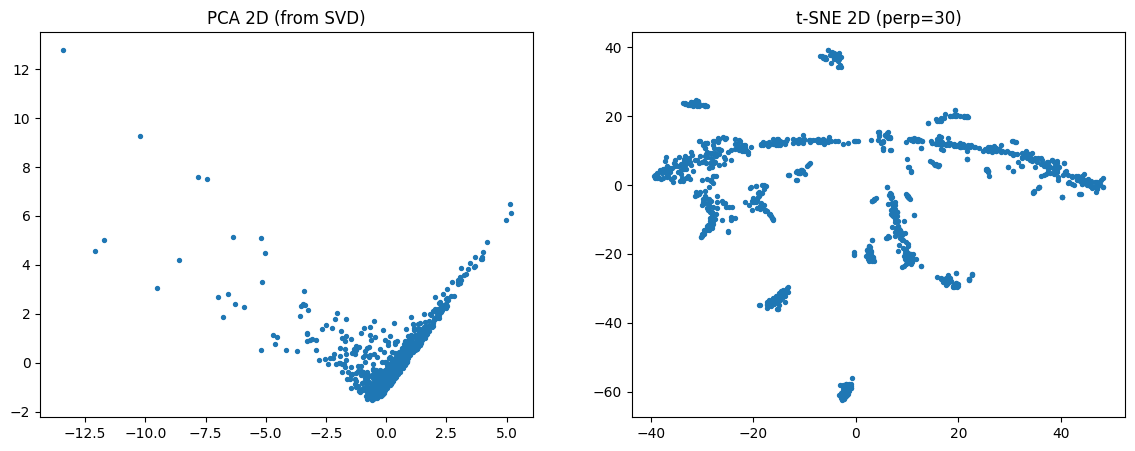

In [45]:
# Visualize embeddings
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.scatter(pca_2[:,0], pca_2[:,1], s=8)
ax1.set_title('PCA 2D (from SVD)')
ax2.scatter(tsne_2[:,0], tsne_2[:,1], s=8)
ax2.set_title(f't-SNE 2D (perp={perp})')
plt.show()

In [46]:
# Clustering: KMeans
inertia = []
sil = []
K_range = list(range(2, min(12, X_svd.shape[0])))
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_svd)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X_svd, labels) if len(np.unique(labels))>1 else np.nan)


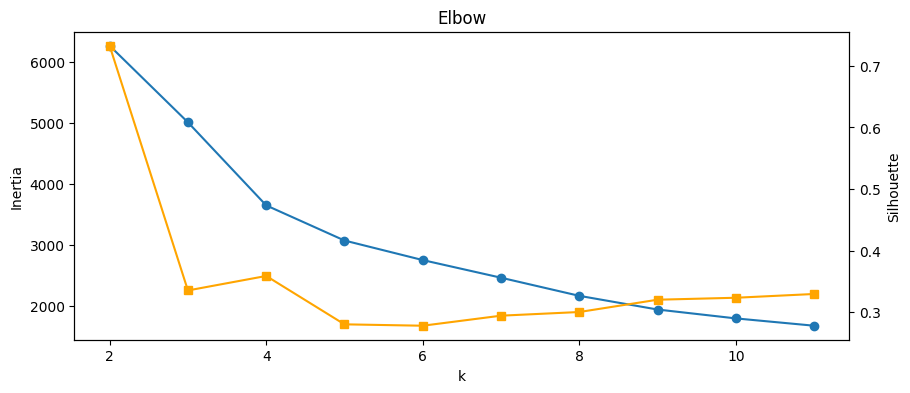

In [47]:
plt.figure(figsize=(10,4))
plt.plot(K_range, inertia, '-o', label='inertia')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow')
ax2 = plt.twinx()
ax2.plot(K_range, sil, '-s', color='orange', label='silhouette')
ax2.set_ylabel('Silhouette')
plt.show()

In [48]:
best_k = K_range[int(np.nanargmax(sil))]
print('Candidate best_k by silhouette:', best_k)

Candidate best_k by silhouette: 2


In [50]:
kmeans_models = {}
for k in sorted(set([max(2, best_k-1), best_k, best_k+1])):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labs = km.fit_predict(X_svd)
    kmeans_models[f'kmeans_k{k}'] = {'model': km, 'labels': labs}
    print('kmeans_k', k, 'clusters', len(np.unique(labs)))

kmeans_k 2 clusters 2
kmeans_k 3 clusters 3


In [52]:
# Agglomerative
agg_models = {}
for k in [max(2, best_k-1), best_k, best_k+1]:
    agg = AgglomerativeClustering(n_clusters=k)
    labs = agg.fit_predict(X_svd)
    agg_models[f'agg_k{k}'] = {'model': agg, 'labels': labs}


In [53]:
# DBSCAN
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(X_svd)
dists,_ = nbrs.kneighbors(X_svd)
k_dist = np.sort(dists[:, -1])
eps_candidates = np.quantile(k_dist, [0.90, 0.93, 0.95, 0.97, 0.99])
db_models = {}
for eps in eps_candidates:
    db = DBSCAN(eps=float(eps), min_samples=5)
    labs = db.fit_predict(X_svd)
    db_models[f'db_eps_{eps:.4f}'] = {'model': db, 'labels': labs}


In [54]:
# Evaluation helper
results = {}
def evaluate_clustering(name, labels, repr_X):
    uniq = np.unique(labels)
    n_clusters = len([l for l in uniq if l!=-1])
    rec = {'n_clusters': n_clusters}
    if n_clusters > 1:
        rec['silhouette'] = silhouette_score(repr_X, labels)
        rec['davies_bouldin'] = davies_bouldin_score(repr_X, labels)
    else:
        rec['silhouette'] = np.nan
        rec['davies_bouldin'] = np.nan
    results[name] = rec


In [55]:
for d in (kmeans_models, agg_models, db_models):
    for name, info in d.items():
        evaluate_clustering(name, info['labels'], X_svd)

res_df = pd.DataFrame(results).T.sort_values(by='silhouette', ascending=False)
display(res_df.head(10))

,n_clusters,silhouette,davies_bouldin
agg_k2,2.0,0.733074,1.177416
kmeans_k2,2.0,0.732694,1.171343
agg_k3,3.0,0.712991,0.604032
kmeans_k3,3.0,0.352040,1.160552
db_eps_1.1404,9.0,0.184738,1.793456
db_eps_1.3597,2.0,0.056443,1.749516
db_eps_1.5512,1.0,NaN,NaN
db_eps_2.0238,1.0,NaN,NaN
db_eps_3.3569,1.0,NaN,NaN


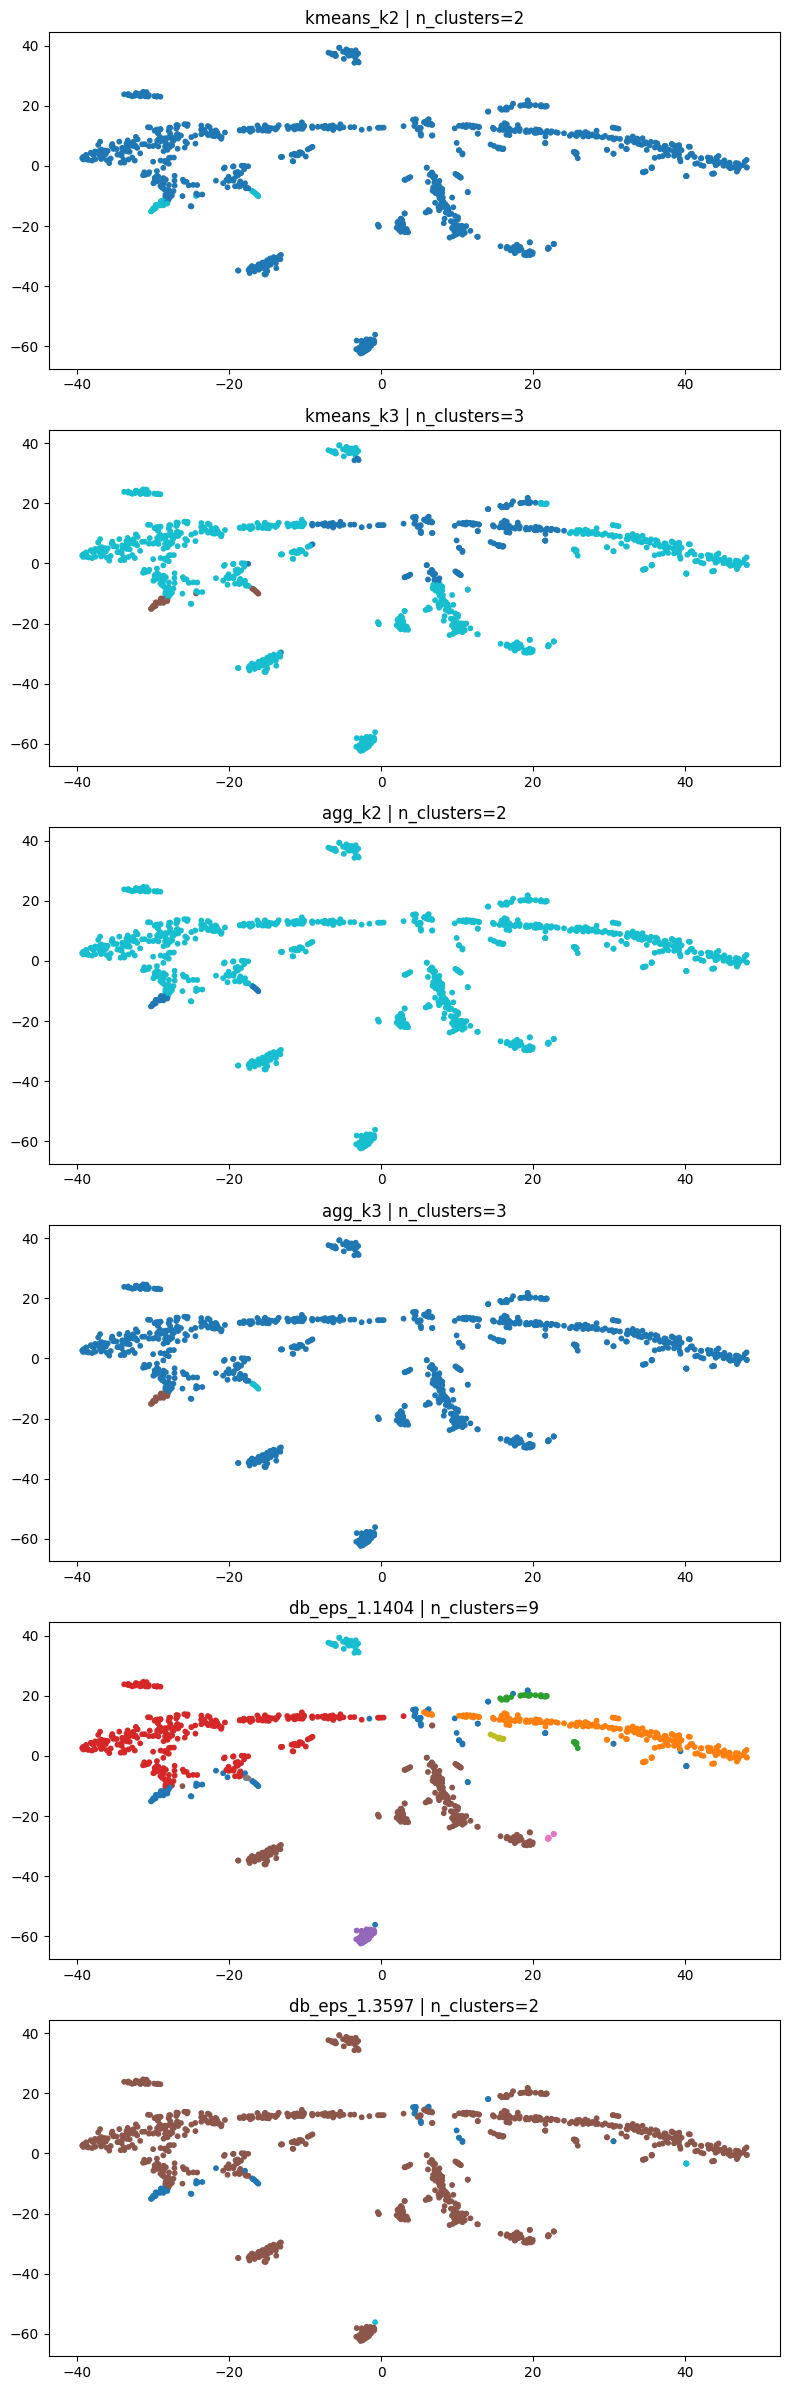

In [56]:
# Visualize a handful of models on t-SNE 2D
display_models = {}
display_models.update({k: v['labels'] for k,v in kmeans_models.items()})
display_models.update({k: v['labels'] for k,v in agg_models.items()})
display_models.update({k: v['labels'] for k,v in db_models.items()})

nplots = min(6, len(display_models))
fig, axes = plt.subplots(nplots, 1, figsize=(8, 4*nplots))
if nplots==1: axes=[axes]
for ax, (name, labels) in zip(axes, list(display_models.items())[:nplots]):
    ax.scatter(tsne_2[:,0], tsne_2[:,1], c=labels, s=10, cmap='tab10')
    ncl = len(set(labels)) - (1 if -1 in labels else 0)
    ax.set_title(f"{name} | n_clusters={ncl}")
plt.tight_layout()
plt.show()

In [57]:
# Choose final model
valid = {n: r for n,r in results.items() if not np.isnan(r['silhouette'])}
best_model_name = sorted(valid.items(), key=lambda x: x[1]['silhouette'], reverse=True)[0][0]
print('Best model by silhouette:', best_model_name)

Best model by silhouette: agg_k2


In [58]:
# Retrieve the labels from the dicts
final_labels = None
for d in (kmeans_models, agg_models, db_models):
    if best_model_name in d:
        final_labels = d[best_model_name]['labels']
        break

In [59]:
out_df = df.copy()
out_df['cluster_label'] = final_labels if final_labels is not None else -1
out_df['pca2_x'] = pca_2[:,0]
out_df['pca2_y'] = pca_2[:,1]
out_df['tsne2_x'] = tsne_2[:,0]
out_df['tsne2_y'] = tsne_2[:,1]

In [60]:
out_csv = 'fragrance_clusters_and_projections.csv'
out_df.to_csv(out_csv, index=False)
print('Saved cluster assignments & projections to', out_csv)

Saved cluster assignments & projections to fragrance_clusters_and_projections.csv


In [61]:
profile = out_df.groupby('cluster_label').agg(
    count=('cluster_label','size'),
    mean_price=('price','mean'),
    median_price=('price','median'),
    mean_sold=('sold','mean')
).reset_index().sort_values('count', ascending=False)
display(profile)

,cluster_label,count,mean_price,median_price,mean_sold
1,1,975,46.987292,35.99,486.719298
0,0,25,26.743600,25.23,11601.520000


In [62]:
profile.to_csv('cluster_profiles_summary.csv', index=False)
print('Saved cluster profile summary to cluster_profiles_summary.csv')

Saved cluster profile summary to cluster_profiles_summary.csv


In [63]:
if 'title' in df.columns and 'cluster_label' in out_df.columns:
    tfidf_vect = tfidf
    toks = np.array(tfidf_vect.get_feature_names_out())
    X_text_array = X_text.toarray() if hasattr(X_text, 'toarray') else X_text.todense()
    out_df['cluster_label'] = out_df['cluster_label'].astype(int)
    top_terms = {}
    for cl in sorted(out_df['cluster_label'].unique()):
        idx = out_df[out_df['cluster_label']==cl].index
        if len(idx) == 0: continue
        mean_vec = X_text[idx,:].mean(axis=0).A1
        top_idx = mean_vec.argsort()[-10:][::-1]
        top_terms[cl] = ', '.join(toks[top_idx])
    top_terms_df = pd.DataFrame([
        {'cluster_label': cl, 'top_terms': top_terms[cl]} for cl in top_terms
    ])
    display(top_terms_df)
    top_terms_df.to_csv('cluster_top_terms.csv', index=False)
    print('Saved cluster top terms to cluster_top_terms.csv')

,cluster_label,top_terms
0,0,"edt, new box, cologne, box eau, box, new, eau ..."
1,1,"eau, parfum, toilette, eau toilette, men, colo..."


Saved cluster top terms to cluster_top_terms.csv
